# Leverage KeyBERT, HDBSCAN and Zephyr-7B-Beta to Build a Knowledge Graph
https://towardsdatascience.com/leverage-keybert-hdbscan-and-zephyr-7b-beta-to-build-a-knowledge-graph-33d7534ee01b

In [1]:
# !pip install llama-index Ipython langchain keybert transformers

In [19]:
import sys

sys.path.append("utils")
import textwrap

import matplotlib.pyplot as plt
import pandas as pd
from keybert import KeyBERT, KeyLLM
from keybert.llm import TextGeneration
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

from utils.arxiv_parser import *
from utils.llm_utils import *

pd.set_option('display.max_colwidth', 100)  # Set the maximum width to 100 for all columns

In [2]:
DATA_DIR = "data/"
llm_path = "../../LLMs/text-generation-webui/models/TheBloke/zephyr-7B-beta-GPTQ/"

In [3]:
# Initialize the data parser
parser = ArXivDataProcessor(DATA_DIR)

# Unzip the downloaded file to extract a json file in data_path
parser.unzip_file()

# Select a topic and extract the articles on that topic
topic = 'cs'
entries = parser.select_topic('cs')

# Build a pandas dataframe with specified selections
df = parser.select_articles(
  entries,  # extracted articles
  cols=['id', 'title', 'abstract'],  # features to keep
  min_length=100,  # min tokens an abstract should have
  max_length=120,  # max tokens an abstract should have
  keep_abs_length=False,  # do not keep the abs_length column
  build_corpus=False)  # do not build a corpus column

# Save the selected data to a csv file 'selected_{topic}.csv', uses data_path
parser.save_selected_data(df, topic)

There are 7149 with cs topic.
There are 983 articles selected.


In [4]:
# question = "What NFL team won the Super Bowl in the year Justin Bieber was born?"
# prompt=f'''<|system|>
# </s>
# <|user|>
# {question}</s>
# <|assistant|>
# '''

In [5]:
llm = AutoModelForCausalLM.from_pretrained(
  llm_path, device_map="auto", trust_remote_code=False,
  revision="main")  # change revision for a different branch
tokenizer = AutoTokenizer.from_pretrained(llm_path, use_fast=True)

CUDA extension not installed.
CUDA extension not installed.


In [6]:
generator = pipeline(
  model=llm,
  tokenizer=tokenizer,
  task='text-generation',
  max_new_tokens=50,
  repetition_penalty=1.1,
)

In [7]:
# response = generator(prompt)
# print(textwrap.fill(response[0]['generated_text'],90))

In [8]:
prompt_keywords = """
<|system|>
I have the following document:
Semantics and Termination of Simply-Moded Logic Programs with Dynamic Scheduling
and five candidate keywords:
scheduling, logic, semantics, termination, moded

Based on the information above, extract the keywords or the keyphrases that best describe the topic of the text.
Follow the requirements below:
1. Make sure to extract only the keywords or keyphrases that appear in the text.
2. Provide five keywords or keyphrases! Do not number or label the keywords or the keyphrases!
3. Do not include anything else besides the keywords or the keyphrases! I repeat do not include any comments!

semantics, termination, simply-moded, logic programs, dynamic scheduling</s>

<|user|>
I have the following document:
[DOCUMENT]
and five candidate keywords:
[CANDIDATES]

Based on the information above, extract the keywords or the keyphrases that best describe the topic of the text.
Follow the requirements below:
1. Make sure to extract only the keywords or keyphrases that appear in the text.
2. Provide five keywords or keyphrases! Do not number or label the keywords or the keyphrases!
3. Do not include anything else besides the keywords or the keyphrases! I repeat do not include any comments!</s>

<|assistant|>
"""

In [9]:
# KeyBert TextGeneration pipeline wrapper
llm_tg = TextGeneration(generator, prompt=prompt_keywords)

# Instantiate KeyBERT and specify an embedding model
kw_model = KeyBERT(llm=llm_tg, model="all-mpnet-base-v2")

/home/ehsan/anaconda3/envs/nlp_toolbox_py310/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [10]:
# Retain the articles titles only for analysis
titles_list = df.title.tolist()

# Process the documents and collect the results
titles_keys = kw_model.extract_keywords(titles_list, threshold=0.5)

# Add the results to df
df["titles_keys"] = titles_keys
df.head()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/ehsan/anaconda3/envs/nlp_toolbox_py310/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Se

,id,title,abstract,titles_keys
0,0001001,Von Neumann Quantum Logic vs. Classical von Ne...,The name of John von Neumann is common both ...,"[von neumann, quantum logic, classical von neu..."
1,0001002,Minimum Description Length and Compositionality,We present a non-vacuous definition of compo...,"[minimum description length, compositionality,..."
4,0001005,Effect of different packet sizes on RED perfor...,We consider the adaptation of random early d...,"[packet sizes, RED performance, different pack..."
6,0001007,RED behavior with different packet sizes,We consider the adaptation of random early d...,"[packet sizes, RED performance, different pack..."
25,0001026,A Logic for SDSI's Linked Local Name Spaces,Abadi has introduced a logic to explicate th...,"[SDSI, linked local names, logic, LLN spaces, ..."


In [11]:
df.to_csv("data/selected_cs.csv", index=False)

In [16]:
df[['title','titles_keys']].head()

,title,titles_keys
0,Von Neumann Quantum Logic vs. Classical von Neumann Architecture?,"[von neumann, quantum logic, classical von neumann architecture, quantum, logic]"
1,Minimum Description Length and Compositionality,"[minimum description length, compositionality, description length, compression, compositional le..."
4,Effect of different packet sizes on RED performance,"[packet sizes, RED performance, different packet sizes, effect, performance]"
6,RED behavior with different packet sizes,"[packet sizes, RED performance, different packet sizes, effect, performance]"
25,A Logic for SDSI's Linked Local Name Spaces,"[SDSI, linked local names, logic, LLN spaces, sdsi-graphs]"


In [17]:
df["len_keys"] = df["titles_keys"].apply(lambda x: len(x))
df.head()


,id,title,abstract,titles_keys,len_keys
0,0001001,Von Neumann Quantum Logic vs. Classical von Neumann Architecture?,The name of John von Neumann is common both in quantum mechanics and computer\nscience. Are th...,"[von neumann, quantum logic, classical von neumann architecture, quantum, logic]",5
1,0001002,Minimum Description Length and Compositionality,We present a non-vacuous definition of compositionality. It is based on the\nidea of combining...,"[minimum description length, compositionality, description length, compression, compositional le...",5
4,0001005,Effect of different packet sizes on RED performance,We consider the adaptation of random early detection (RED) as an active queue\nmanagement algo...,"[packet sizes, RED performance, different packet sizes, effect, performance]",5
6,0001007,RED behavior with different packet sizes,We consider the adaptation of random early detection (RED) as a buffer\nmanagement algorithm f...,"[packet sizes, RED performance, different packet sizes, effect, performance]",5
25,0001026,A Logic for SDSI's Linked Local Name Spaces,"Abadi has introduced a logic to explicate the meaning of local names in SDSI,\nthe Simple Dist...","[SDSI, linked local names, logic, LLN spaces, sdsi-graphs]",5


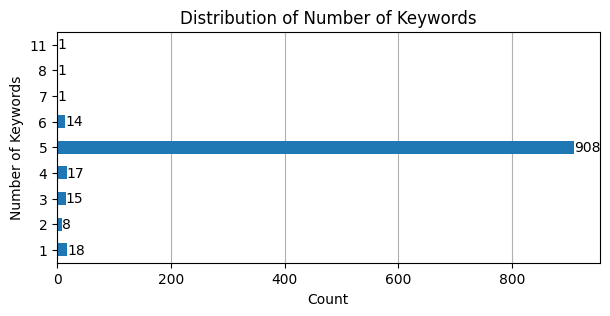

In [29]:
ax = df['len_keys'].value_counts().sort_index().plot(kind='barh', figsize=(7, 3), zorder=2)
for p in ax.patches:
    ax.text(p.get_width(), p.get_y() + p.get_height()/2, str(p.get_width()), ha='left', va='center')
plt.xlabel('Count')
plt.ylabel('Number of Keywords')
plt.title('Distribution of Number of Keywords')
plt.grid(axis='x')
plt.show()
